## Inverse FFD

"Fitting mesh deformation to Free-Form Deformation (namely, inverse FFD)"  

### Requirements

- [numpy], [scipy]  
- [matplotlib]  
- **[libigl]**: Right now, I utilize this library for the following purposes.  
  + **igl.read_obj()**: load obj file  
  + **igl.extract_manifold_patches()**: separate to submeshes  
  + **igl.vertex_triangle_adjacency()**: get the faces that linked to vertex  

[numpy]:https://numpy.org/
[scipy]:https://www.scipy.org/
[matplotlib]:https://matplotlib.org/
[libigl]:https://libigl.github.io/libigl-python-bindings/

## TODOs

These will takes several efforts, so I just note them.  

- Keeping consistency between forward and inverse FFD  


In [1]:
## load mesh data with libigl
import numpy as np
import igl

## load full mesh
x_full, u_full, _, tri_full, _, _ = igl.read_obj('data/4.obj')

x_full = x_full[:,:2] ## reduce vertex dimension: 3D -> 2D

In [2]:
selected = 3 ## [TEMPORARY]

## separate mesh
tri_subs = igl.extract_manifold_patches(tri_full)

## compute vertex to face correspondence in advance
v2f = igl.vertex_triangle_adjacency(tri_full, len(x_full))

<IPython.core.display.Javascript object>


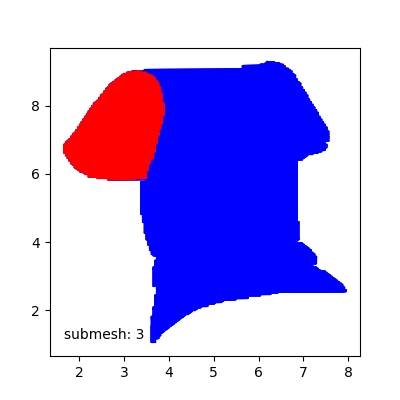

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure(figsize=(4,4))
ax0 = fig.add_subplot(111)
line, = ax0.plot(x_full[:,0], x_full[:,1], c='b', picker=1)

text = ax0.text(np.min(x_full[:,0]), np.min(x_full[:,1]), "mesh: ", va="bottom", ha="left")

def onpick(event):
    global selected

    if event.artist!=line: return True
    if not len(event.ind): return True
    
    ax0.plot(x_full[:,0], x_full[:,1], c='b')

    ## get the clicked point
    thisline = event.artist
    xdata = thisline.get_xdata()
    ydata = thisline.get_ydata()
    ind = event.ind
    
    ## get the submesh id
    selected = tri_subs[1][v2f[0][v2f[1][ind[0]]]]
    text.set_text('submesh: {0}'.format(selected)) ## show as text
    
    ## visualize the clicked submesh
    tri_sub  = tri_full[tri_subs[1]==selected]
    vidx_sub = np.unique(tri_sub.reshape(-1))
    x = x_full[vidx_sub]
    ax0.plot(x[:,0], x[:,1], c='r')
    
    return True

fig.canvas.mpl_connect('pick_event', onpick)
plt.show()

In [4]:
## select the specific index from user-clicking point
tri_sub = tri_full[tri_subs[1]==selected]

## separate submesh from full mesh
vidx_sub = np.unique(tri_sub.reshape(-1))
x = x_full[vidx_sub]
u = u_full[vidx_sub]

## convert vertex indices for submesh
N = x.shape[0]
vidx = np.arange(0, x.shape[0])

vidx_full_to_sub = {}
for a,b in zip(vidx_sub, vidx):
    vidx_full_to_sub[a] = b

tri = [np.array([vidx_full_to_sub[v0],
                 vidx_full_to_sub[v1],
                 vidx_full_to_sub[v2]])
       for v0, v1, v2 in tri_sub]

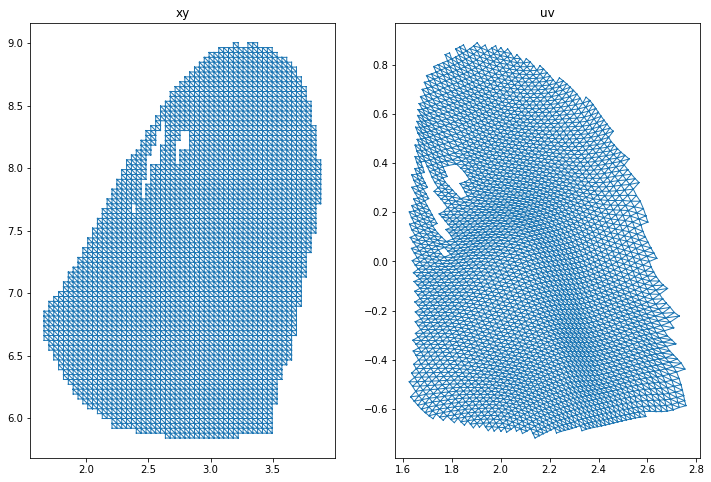

In [5]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

############################################################
## XY-space
############################################################
ax1.set_title('xy')

ax1.triplot(x[:,0], x[:,1], tri, linewidth=1)

############################################################
## UV-space
############################################################
ax2.set_title('uv')

ax2.triplot(u[:,0], u[:,1], tri, linewidth=1)

plt.show()

### Procedure

#### 1. Initialization: UV grid

1. Compute bounding box  
2. Subdivision few times **$\leftarrow$ [TODO]**  
3. Obtain grid points $B_{ij}$ on subdivided bounding box  


In [6]:
## compute bounding box
u_min, u_max = np.min(u[:,0]), np.max(u[:,0])
v_min, v_max = np.min(u[:,1]), np.max(u[:,1])

########################################
## compute visualization range
## suppose: vertical > horizontal
########################################
percentile = 0.05
aspect = (u_max-u_min) / (v_max-v_min)

## uv
eps = percentile * (v_max-v_min)
v_min_vis = v_min - eps
v_max_vis = v_max + eps
u_min_vis = (u_max+u_min)*0.5 - (v_max_vis-v_min_vis)*0.5
u_max_vis = (u_max+u_min)*0.5 + (v_max_vis-v_min_vis)*0.5

if aspect > 1.0:
    eps = percentile * (u_max-u_min)
    u_min_vis = u_min - eps
    u_max_vis = u_max + eps
    v_min_vis = (v_max+v_min)*0.5 - (u_max_vis-u_min_vis)*0.5
    v_max_vis = (v_max+v_min)*0.5 + (u_max_vis-u_min_vis)*0.5

print(u_min, v_min, u_max, v_max)

1.62583 -0.7189 2.75779 0.88979


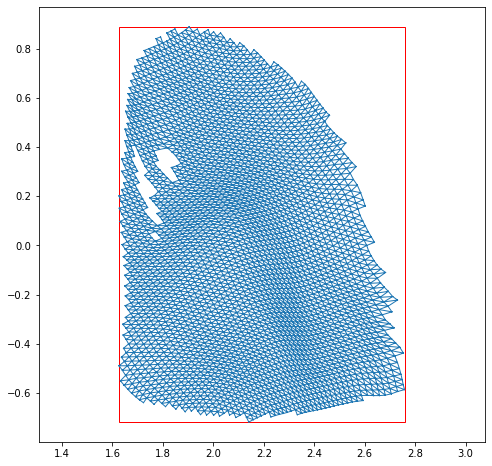

In [7]:
## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([u_min_vis, u_max_vis])
ax.set_ylim([v_min_vis, v_max_vis])
ax.triplot(u[:,0], u[:,1], tri, linewidth=1.0)

ax.add_patch(Rectangle((u_min, v_min), u_max-u_min, v_max-v_min, edgecolor='red', fill=False))

plt.show()

In [8]:
import ipywidgets as widgets
from IPython.display import display

subdiv_u = widgets.IntSlider(value=6, min=3, max=20)
subdiv_v = widgets.IntSlider(value=8, min=3, max=20)

display(subdiv_u)
display(subdiv_v)

IntSlider(value=6, max=20, min=3)

IntSlider(value=8, max=20, min=3)

In [9]:
## subdivide bounding box
B_i = np.linspace(u_min, u_max, num=subdiv_u.value)
B_j = np.linspace(v_min, v_max, num=subdiv_v.value)

B_ix, B_jy = np.meshgrid(B_i, B_j)

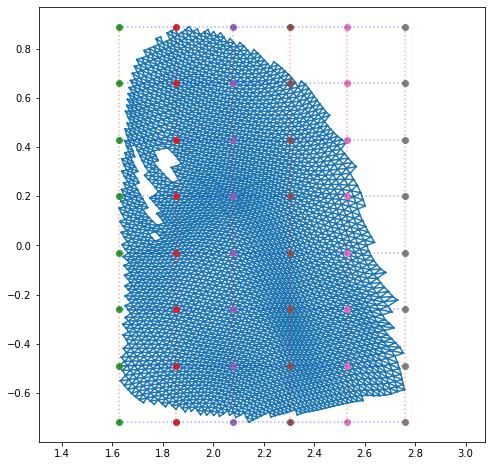

In [10]:
## visualize bounding box
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([u_min_vis, u_max_vis])
ax.set_ylim([v_min_vis, v_max_vis])

ax.triplot(u[:,0], u[:,1], tri)

## grid points
ax.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    plt.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    plt.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

plt.show()

In [11]:
## get the grid points B_{ij}
B_ij = np.dstack((B_ix, B_jy)).reshape(-1,2)

#### 2. Construct least-squares problem



In [12]:
## construct sparse matrix
from scipy.sparse import dok_matrix

## allocate sparse matrix with additional rows for grid constraints
i = B_i.shape[0]
j = B_j.shape[0]
rows = 2*(x.shape[0] + (i-2)*j + i*(j-2) )
B_tilde = dok_matrix((rows, i*j*2), dtype=np.float32)

def ForEachUV(k, u_k, v_k):
    
    for i in range(len(B_i)-1):
        if (B_i[i] <= u_k and u_k <= B_i[i+1]):
            break
    
    for j in range(len(B_j)-1):
        if (B_j[j] <= v_k and v_k <= B_j[j+1]):
            break
    
    w_i = (B_i[i+1]-u_k) / (B_i[i+1]-B_i[i])
    w_j = (B_j[j+1]-v_k) / (B_j[j+1]-B_j[j])
    
    #print("{0},\t{1} \t-> ({2},{3}), weight = ({4},{5})".format(u_k, v_k, i, j, w_i, w_j))
    
    ## assign each elements into sparse matrix
    B_row = 2 * k

    B_col_i0j0 = 2 * ((i+0) + (j+0)*len(B_i) )
    B_col_i1j0 = 2 * ((i+1) + (j+0)*len(B_i) )
    B_col_i0j1 = 2 * ((i+0) + (j+1)*len(B_i) )
    B_col_i1j1 = 2 * ((i+1) + (j+1)*len(B_i) )
    
    B_tilde[B_row  , B_col_i0j0  ] = w_i*w_j
    B_tilde[B_row+1, B_col_i0j0+1] = w_i*w_j
    B_tilde[B_row  , B_col_i0j1  ] = w_i*(1.0-w_j)
    B_tilde[B_row+1, B_col_i0j1+1] = w_i*(1.0-w_j)
    
    B_tilde[B_row  , B_col_i1j0  ] = (1.0-w_i)*w_j
    B_tilde[B_row+1, B_col_i1j0+1] = (1.0-w_i)*w_j
    B_tilde[B_row  , B_col_i1j1  ] = (1.0-w_i)*(1.0-w_j)
    B_tilde[B_row+1, B_col_i1j1+1] = (1.0-w_i)*(1.0-w_j)
    
    return None

for k in range(len(u)):
    uv_k = u[k]
    ForEachUV(k, uv_k[0], uv_k[1])

############################################################
## additional constraints among grid points
############################################################
grid_weight = 0.1

## u-direction
cnt = 0
for i in range(1,len(B_i)-1):
    for j in range(len(B_j)):

        B_row = 2 * ( len(u) + cnt )
        B_col_i0j1 = 2 * ((i-1) + (j+0)*len(B_i) )
        B_col_i1j1 = 2 * ((i+0) + (j+0)*len(B_i) )
        B_col_i2j1 = 2 * ((i+1) + (j+0)*len(B_i) )
        
        B_tilde[B_row  , B_col_i0j1  ] = grid_weight
        B_tilde[B_row+1, B_col_i0j1+1] = grid_weight
        B_tilde[B_row  , B_col_i1j1  ] = -2.0 * grid_weight
        B_tilde[B_row+1, B_col_i1j1+1] = -2.0 * grid_weight
        B_tilde[B_row  , B_col_i2j1  ] = grid_weight
        B_tilde[B_row+1, B_col_i2j1+1] = grid_weight
        
        cnt+=1

## v-direction
cnt = 0
for i in range(len(B_i)):
    for j in range(1,len(B_j)-1):

        B_row = 2 * ( len(u) + (len(B_i)-2)*len(B_j) + cnt )
        B_col_i1j0 = 2 * ((i+0) + (j-1)*len(B_i) )
        B_col_i1j1 = 2 * ((i+0) + (j+0)*len(B_i) )
        B_col_i1j2 = 2 * ((i+0) + (j+1)*len(B_i) )
        
        B_tilde[B_row  , B_col_i1j0  ] = grid_weight
        B_tilde[B_row+1, B_col_i1j0+1] = grid_weight
        B_tilde[B_row  , B_col_i1j1  ] = -2.0 * grid_weight
        B_tilde[B_row+1, B_col_i1j1+1] = -2.0 * grid_weight
        B_tilde[B_row  , B_col_i1j2  ] = grid_weight
        B_tilde[B_row+1, B_col_i1j2+1] = grid_weight
        
        cnt+=1


In [13]:
## constant part: make it as 1-dim vector + concat zero-vector
i = B_i.shape[0]
j = B_j.shape[0]
x_tilde = np.concatenate([x.reshape(-1), np.zeros([2*( (i-2)*j + i*(j-2) )])])

#### 3. Solve least-squares problem

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html  

In [14]:
## solve Least-Squares problem with scipy.sparse:
from datetime import datetime
from scipy.sparse.linalg import lsqr

print("try to solve LS...")

start = datetime.now()

P_tilde, isstop, itn, r1norm = lsqr(B_tilde, x_tilde)[:4]

end = datetime.now()

print(isstop, itn, r1norm)
print("elapsed time: {0} [sec]".format( (end-start).total_seconds() ))

try to solve LS...
2 70 0.7037615333044601
elapsed time: 14.324049 [sec]


#### 4. Post-process

- Revert to 2-dimensional vector  
- Visualize both spaces

In [15]:
## revert to the original 2-dimensional vector
P = P_tilde.reshape(-1,2)

## prepare data for visualization
P_i, P_j = P.T
P_ix = P_i.reshape(len(B_j), len(B_i))
P_jy = P_j.reshape(len(B_j), len(B_i))

In [16]:
## compute xy visualization range
x_min, x_max = np.min(P[:,0]), np.max(P[:,0])
y_min, y_max = np.min(P[:,1]), np.max(P[:,1])

eps = percentile * (y_max-y_min)
y_min_vis = y_min - eps
y_max_vis = y_max + eps
x_min_vis = (x_max+x_min)*0.5 - (y_max_vis-y_min_vis)*0.5
x_max_vis = (x_max+x_min)*0.5 + (y_max_vis-y_min_vis)*0.5

aspect = (x_max-x_min) / (y_max-y_min)

if aspect > 1.0:
    eps = percentile * (x_max-x_min)
    x_min_vis = x_min - eps
    x_max_vis = x_max + eps
    y_min_vis = (y_max+y_min)*0.5 - (x_max_vis-x_min_vis)*0.5
    y_max_vis = (y_max+y_min)*0.5 + (x_max_vis-x_min_vis)*0.5

print(x_min, y_min, x_max, y_max)

1.5070342693428673 5.6921764271484685 4.510855190169595 9.157708554339456


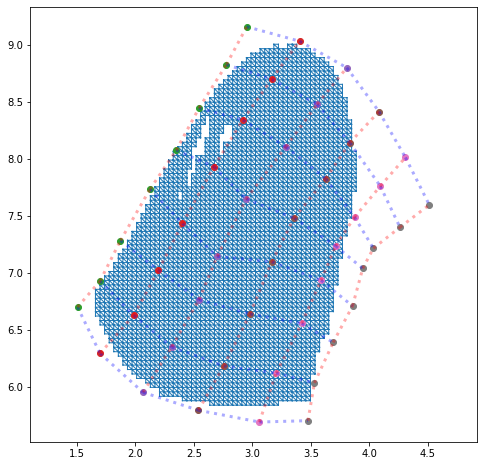

In [17]:
## visualize control points in X-space
fig, ax = plt.subplots(figsize=(8,8))

ax.set_xlim([x_min_vis,x_max_vis])
ax.set_ylim([y_min_vis,y_max_vis])

ax.triplot(x[:,0], x[:,1], tri, linewidth=1.0)

## grid points
ax.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        plt.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':', linewidth=3.0)

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        plt.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':', linewidth=3.0)

plt.show()

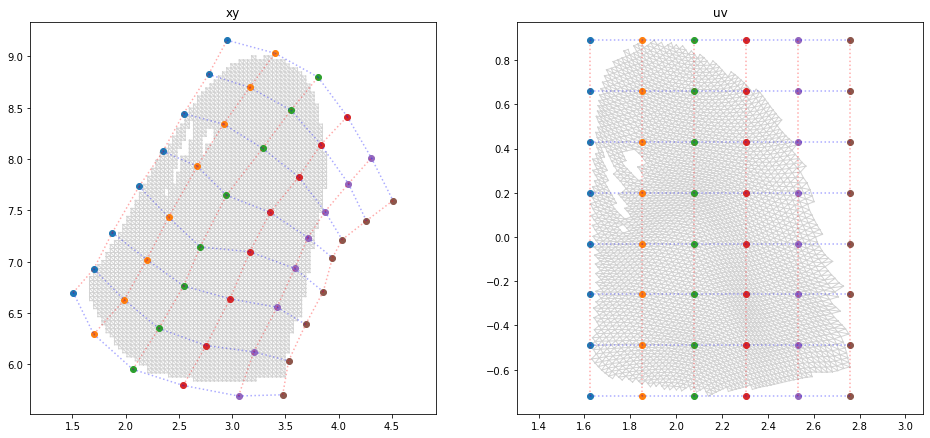

In [18]:
## visualize mesh data by Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7.2))

########################################
## XY space
########################################
ax1.set_xlim([x_min_vis,x_max_vis])
ax1.set_ylim([y_min_vis,y_max_vis])

ax1.triplot(x[:,0], x[:,1], tri, linewidth=1, color='lightgray')

## grid points
ax1.plot(P_ix, P_jy, 'o')

## draw lines
for j in range(P_ix.shape[0]):
    for i in range(P_ix.shape[1]-1):
        ax1.plot([P_ix[j,i], P_ix[j,i+1]], [P_jy[j,i], P_jy[j,i+1]], color='blue', alpha=.33, linestyle=':')

for i in range(P_ix.shape[1]):
    for j in range(P_ix.shape[0]-1):
        ax1.plot([P_ix[j,i], P_ix[j+1,i]], [P_jy[j,i], P_jy[j+1,i]], color='red', alpha=.33, linestyle=':')

########################################
## UV space
########################################
ax2.set_xlim([u_min_vis, u_max_vis])
ax2.set_ylim([v_min_vis, v_max_vis])

ax2.triplot(u[:,0], u[:,1], tri, linewidth=1, color='lightgray')

## grid points
ax2.plot(B_ix, B_jy, 'o')

## draw lines between grid points
for Bx in B_i:
    ax2.plot([Bx, Bx], [B_j[0], B_j[-1]], color='red', alpha=.33, linestyle=':')
for By in B_j:
    ax2.plot([B_i[0], B_i[-1]], [By, By], color='blue', alpha=.33, linestyle=':')

ax1.set_title('xy')
ax2.set_title('uv')

plt.show()

(end)